<a href="https://colab.research.google.com/github/patrick-seib/econ-489/blob/main/489_government_spending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base import  datetools

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


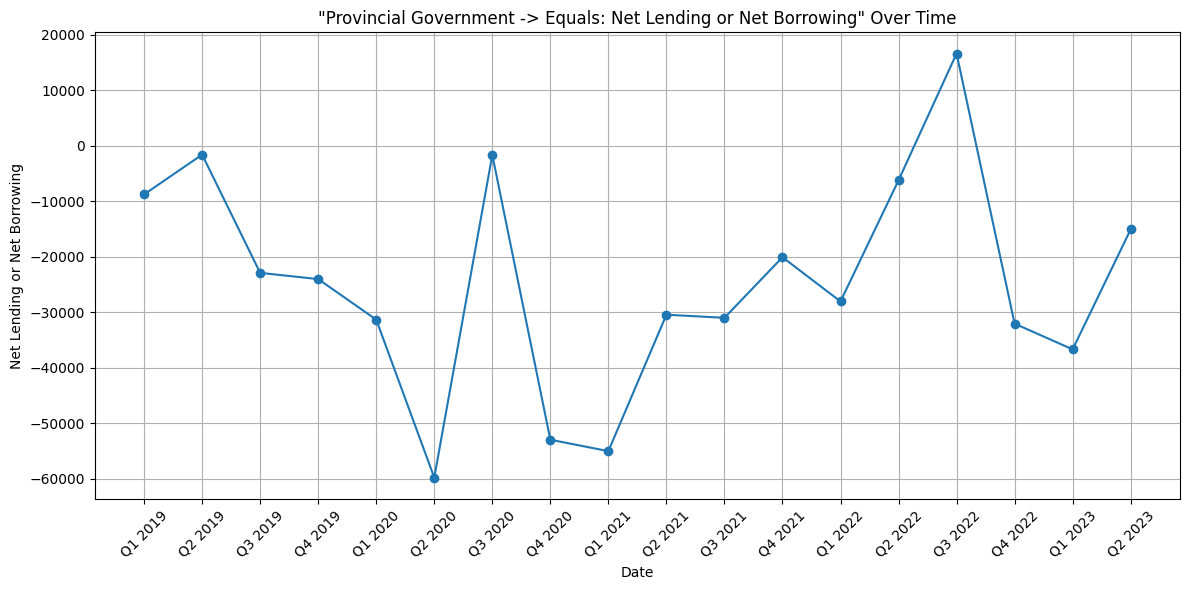

In [32]:
prov_data = pd.read_csv('/content/drive/My Drive/489_Data/provincal_gov_transposed_cleaned_no_dots.csv')
prov_data['Equals: net lending or net borrowing'] = pd.to_numeric(
    prov_data['Equals: net lending or net borrowing'].str.replace(',', ''),
    errors='coerce'
)
plt.figure(figsize=(12, 6))
plt.plot(prov_data['Date'], prov_data['Equals: net lending or net borrowing'], marker='o', linestyle='-')
plt.title('"Provincial Government -> Equals: Net Lending or Net Borrowing" Over Time')
plt.xlabel('Date')
plt.ylabel('Net Lending or Net Borrowing')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

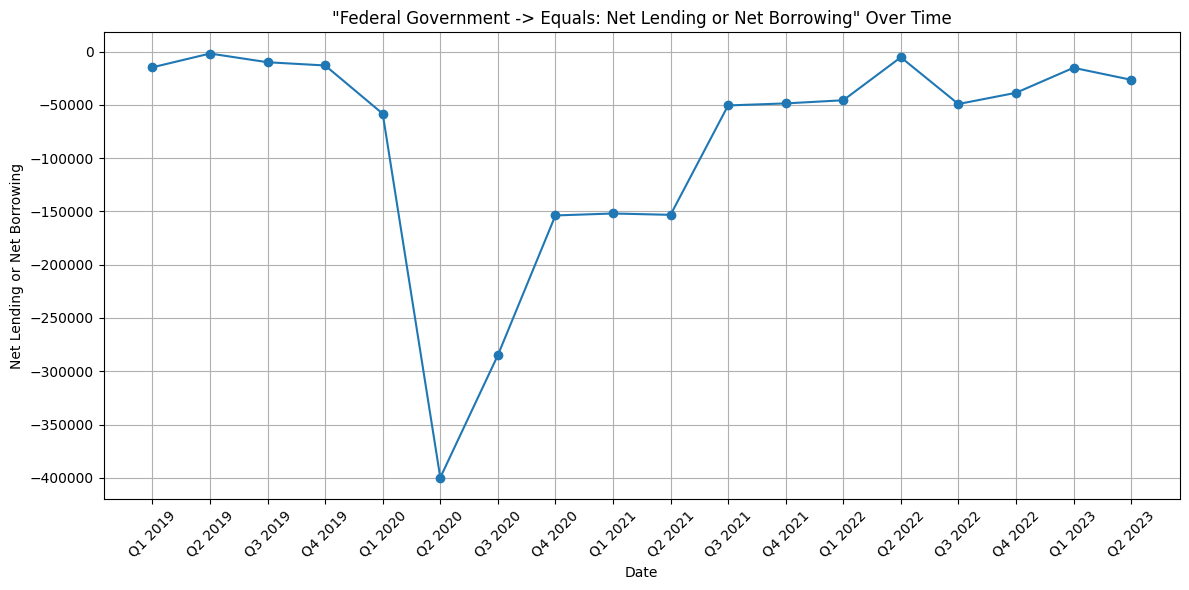

In [33]:
gov_df = pd.read_csv('/content/drive/My Drive/489_Data/federal_gov_expenditure_revenue.csv', index_col=0)
gov_df['Equals: net lending or net borrowing'] = pd.to_numeric(
    gov_df['Equals: net lending or net borrowing'].str.replace(',', ''),
    errors='coerce'
)
plt.figure(figsize=(12, 6))
plt.plot(gov_df.index, gov_df['Equals: net lending or net borrowing'], marker='o', linestyle='-')
plt.title('"Federal Government -> Equals: Net Lending or Net Borrowing" Over Time')
plt.xlabel('Date')
plt.ylabel('Net Lending or Net Borrowing')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

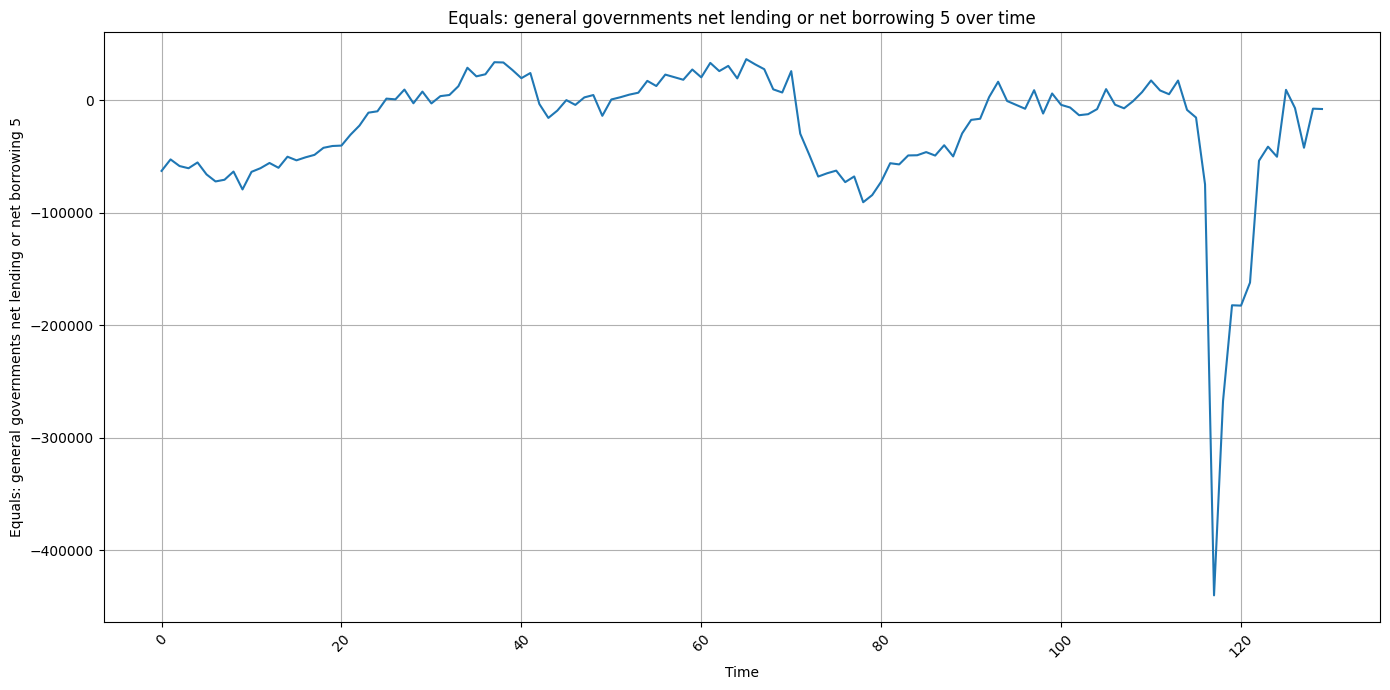

In [34]:
gen_data = pd.read_csv('/content/drive/My Drive/489_Data/cleaned_dataset_general_gov_expenditure.csv')


column_to_plot = 'Equals: general governments net lending or net borrowing 5'
data_to_plot = gen_data[column_to_plot]

# Plotting the data
plt.figure(figsize=(14, 7))
data_to_plot.plot()
plt.title(column_to_plot + ' over time')
plt.xlabel('Time')
plt.ylabel(column_to_plot)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
# Calculate the correlation of each feature with the target column
correlations = gen_data.corrwith(gen_data[column_to_plot])

# Drop the target column correlation (as it will be 1 with itself)
correlations = correlations.drop(column_to_plot, errors='ignore')

# Get the top 6 most influential features based on absolute correlation
top_features = correlations.abs().nlargest(6).index.tolist()

<ipython-input-36-2770f327a042>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = gen_data.corrwith(gen_data[column_to_plot])


['Equals: net general governments saving 4',
 'Net general governments saving 5',
 'Equals: general governments gross saving and capital transfers 5',
 'Less: subsidies on production 1 2',
 'To households 2 3',
 'Less: current transfers paid 2 3']

In [42]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1] <= 0.05  # Return True if p-value <= 0.05 (stationary)

# Collect series that are not stationary
non_stationary = []

# Check stationarity for each series
for feature in top_features + [column_to_plot]:
    if not adf_test(gen_data[feature].dropna()):
        non_stationary.append(feature)

# Difference the non-stationary series
for feature in non_stationary:
    gen_data[feature] = gen_data[feature].diff()

# Check stationarity again after differencing
still_non_stationary = [feature for feature in non_stationary if not adf_test(gen_data[feature].dropna())]

still_non_stationary

[]

In [50]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

# Select the features and target column for the VAR model
var_data = gen_data[top_features + [column_to_plot]].dropna()

# Split the data into training and validation sets (80% train, 20% validation)
train_size = int(len(var_data) * 0.8)
train, validation = var_data[0:train_size], var_data[train_size:]

from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Compute VIF for the top features
vif_values = compute_vif(train[top_features])

# Drop the features with infinite VIF
features_to_drop = vif_values[vif_values["VIF"] == float('inf')]["Variable"].tolist()
selected_features = [feature for feature in top_features if feature not in features_to_drop]

# Retrain the VAR model with the selected features
model = VAR(train[selected_features + [column_to_plot]])
var_model = model.fit()

# Model summary
var_model.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Oct, 2023
Time:                     19:58:56
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    77.6429
Nobs:                     102.000    HQIC:                   77.1835
Log likelihood:          -4614.07    FPE:                2.42588e+33
AIC:                      76.8708    Det(Omega_mle):     1.82285e+33
--------------------------------------------------------------------
Results for equation Equals: general governments gross saving and capital transfers 5
                                                                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------------------------------------
const                                                  